In [1]:
%pylab inline
# %load_ext memory_profiler

import os
import time
import warnings

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
from pomegranate import BayesianNetwork
from pomegranate.utils import plot_networkx
import pygraphviz
import requests
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

warnings.filterwarnings("ignore")

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
os.chdir('./notebooks')

EXTERNAL_DATA = "../data/external/"
START_DATE = "2020-01-01"
END_DATE = "2021-07-01"
URL_MARKET = "https://finance.yahoo.com/world-indices/"
URL_STEEL = "https://en.wikipedia.org/wiki/List_of_steel_producers"
URL_STEEL_PROD = "https://worldsteelprices.com/"


Populating the interactive namespace from numpy and matplotlib


# Aquisição dos dados

Para esse trabalho, 

In [2]:
page = requests.get(URL_MARKET)
soup = BeautifulSoup(page.text, 'html.parser')

df_market = pd.read_html(page.text)[0]

df_market.dropna(axis=1, inplace=True)

df_market.head()

,Symbol,Name,Last Price,Change,% Change,Volume
0,^GSPC,S&P 500,4369.55,48.73,+1.13%,1.795B
1,^DJI,Dow 30,34870.16,448.23,+1.30%,301.753M
2,^IXIC,Nasdaq,14701.92,142.13,+0.98%,3.525B
3,^NYA,NYSE COMPOSITE (DJ),16633.30,273.60,+1.67%,0
4,^XAX,NYSE AMEX COMPOSITE INDEX,3124.88,54.18,+1.76%,0


In [3]:
df_steel_nyse = pd.read_csv(
    EXTERNAL_DATA+'Complete-List-of-Steel-Iron-Stocks-listed-on-NYSE-Jan-10-21.csv', delimiter=';', index_col='S.No.'
    )
df_steel_nyse.dropna(axis=1, inplace=True)

dct_steel_nyse = {}

for row in df_steel_nyse.iterrows():
    # dct_steel_nyse[row[1]['Ticker']] = 1
    dct_steel_nyse[row[1]['Ticker']] = {'name': row[1]['Company'], 'country': row[1]['Country']}

df_steel_nyse

,Company,Ticker,Country
S.No.,,,
1,Allegheny Technologies Incorporated,ATI,USA
2,Arcelor Mittal,MT,Luxembourg
3,Carpenter Technology Corporation,CRS,USA
4,Commercial Metals Company,CMC,USA
5,Companhia Siderurgica Nacional S.A.,SID,Brazil
6,Friedman Industries Inc.,FRD,USA
7,Gerdau S.A.,GGB,Brazil
8,Grupo Simec S.A.B. de C.V.,SIM,Mexico
9,Mechel PAO,MTL,Russia


In [4]:
dct_steel = {
    "CSNA3.SA": {"name":"Companhia Siderúrgica Nacional", "market": "Bovespa", "currency": "BRL"},
    "MT":{"name": "ArcelorMittal NYSE", "market": "NYSE", "currency": "USD"},
    "MT.AS":{"name": "ArcelorMittal Amsterdam", "market": "Amsterdam Delayed Price", "currency": "EUR"},
    "5401.T":{"name": "Nippon Steel Corporation", "market": "Nikkey", "currency": "JPY"},
    "000709.SZ":{"name": "Hesteel Group", "market":"Shenzhen", "currency": "CNY"},
    "PKX":{"name": "POSCO", "market":"NYSE", "currency": "USD"},
    "BRL=X":{"name": "BRL to USD", "market":"currency", "currency": "BRL"}
}

pd.DataFrame.from_dict(dct_steel, orient="index")

,name,market,currency
CSNA3.SA,Companhia Siderúrgica Nacional,Bovespa,BRL
MT,ArcelorMittal NYSE,NYSE,USD
MT.AS,ArcelorMittal Amsterdam,Amsterdam Delayed Price,EUR
5401.T,Nippon Steel Corporation,Nikkey,JPY
000709.SZ,Hesteel Group,Shenzhen,CNY
PKX,POSCO,NYSE,USD
BRL=X,BRL to USD,currency,BRL


In [5]:
df = pd.read_html(URL_STEEL_PROD)[0]
df = df[[column for column in df.columns if 'Unnamed' not in column]].copy()

df.head()


,Month,CARBON STEEL PRICE,CARBON STEEL INDEX,STAINLESS STEEL 304 PRICE,STAINLESS STEEL 304 INDEX
0,Apr-20,614,153.9,2314,123.3
1,Mar-20,642,160.9,2345,124.9
2,Feb-20,643,161.2,2368,126.2
3,Jan-20,644,161.4,2391,127.4
4,Dec-19,620,155.4,2492,132.8


In [6]:
df_steel_nyse = downloading_stocks_data(dct_steel_nyse, start_date=START_DATE, end_date=END_DATE)
df_steel_nyse.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Allegheny Technologies Incorporated,Arcelor Mittal,Carpenter Technology Corporation,Commercial Metals Company,Companhia Siderurgica Nacional S.A.,Friedman Industries Inc.,Gerdau S.A.,Grupo Simec S.A.B. de C.V.,Mechel PAO,Nucor Corporation,POSCO,SunCoke Energy Inc.,Tenaris S.A.,Ternium S.A.,TimkenSteel Corporation,Titan International Inc.,USA Steel Corporation,Worthington Industries Inc.
Date,,,,,,,,,,,,,,,,,,
2020-01-02,20.600000,17.709999,49.480000,22.350000,3.62,6.05,5.09,10.36,2.02,55.119999,51.209999,6.18,22.620001,22.719999,7.73,3.70,10.82,41.709999
2020-01-03,20.510000,16.910000,48.790001,22.180000,3.54,6.00,4.96,10.37,2.01,54.389999,50.310001,5.97,23.010000,22.320000,7.64,3.71,10.74,41.200001
2020-01-06,20.100000,16.660000,48.779999,22.120001,3.45,6.03,4.96,10.76,2.74,53.930000,49.400002,6.25,23.170000,21.709999,7.69,3.96,10.79,41.169998
2020-01-07,20.320000,16.870001,48.500000,22.650000,3.46,6.03,5.03,10.65,2.70,53.810001,49.410000,6.30,23.389999,21.480000,7.70,3.91,11.13,40.860001
2020-01-08,19.680000,16.990000,48.750000,23.170000,3.44,5.97,5.06,10.99,2.97,53.680000,50.049999,6.37,23.200001,21.920000,7.74,3.95,11.10,40.869999
2020-01-09,19.110001,16.840000,48.450001,22.799999,3.39,5.99,4.99,10.61,2.98,53.500000,50.919998,6.16,23.490000,22.480000,7.58,3.87,10.85,40.279999
2020-01-10,18.180000,16.420000,47.270000,22.600000,3.44,5.99,5.07,10.10,2.91,52.770000,51.180000,5.94,23.139999,22.570000,7.49,3.70,10.72,40.290001
2020-01-13,18.480000,16.990000,47.529999,22.600000,3.58,6.01,5.24,10.10,2.82,53.369999,52.200001,6.07,23.090000,23.360001,7.52,3.43,10.72,40.549999
2020-01-14,19.059999,16.870001,48.110001,22.219999,3.56,5.79,5.13,10.05,2.89,54.000000,52.320000,6.11,22.820000,23.430000,7.51,3.43,10.91,40.900002


In [7]:
df_return_in_period = df_steel_nyse.copy()
df_return_in_period = return_in_period(df_return_in_period)

df_return_in_period.tail()

,Allegheny Technologies Incorporated,Arcelor Mittal,Carpenter Technology Corporation,Commercial Metals Company,Companhia Siderurgica Nacional S.A.,Friedman Industries Inc.,Gerdau S.A.,Grupo Simec S.A.B. de C.V.,Mechel PAO,Nucor Corporation,POSCO,SunCoke Energy Inc.,Tenaris S.A.,Ternium S.A.,TimkenSteel Corporation,Titan International Inc.,USA Steel Corporation,Worthington Industries Inc.
Date,,,,,,,,,,,,,,,,,,
2021-06-24,1.089320,1.738566,0.840946,1.422371,2.505525,2.533884,1.222004,2.664093,1.059406,1.775762,1.520406,1.181230,1.000884,1.585387,1.945666,2.362162,2.243993,1.468233
2021-06-25,1.020388,1.752118,0.817300,1.390604,2.408840,2.340496,1.212181,2.811776,1.024752,1.754173,1.517477,1.150485,1.000442,1.597711,1.882277,2.327027,2.184843,1.443059
2021-06-28,1.005340,1.725014,0.792239,1.378076,2.395028,2.267769,1.210216,2.716216,1.014851,1.725508,1.508690,1.106796,0.962865,1.636884,1.800776,2.235135,2.145102,1.429873
2021-06-29,0.987379,1.766234,0.795675,1.361969,2.494475,2.348760,1.194499,2.724904,0.995050,1.716800,1.502441,1.110032,0.959770,1.666813,1.799483,2.208108,2.158965,1.446176
2021-06-30,1.012136,1.753811,0.812854,1.374497,2.425414,2.214876,1.159136,2.780888,1.004950,1.740385,1.499121,1.155340,0.968170,1.692782,1.830530,2.291892,2.218115,1.466795


In [8]:
df_return_in_period.iloc[-1].sort_values(ascending=False)

Grupo Simec S.A.B. de C.V.             2.780888
Companhia Siderurgica Nacional S.A.    2.425414
Titan International Inc.               2.291892
USA Steel Corporation                  2.218115
Friedman Industries Inc.               2.214876
TimkenSteel Corporation                1.830530
Arcelor Mittal                         1.753811
Nucor Corporation                      1.740385
Ternium S.A.                           1.692782
POSCO                                  1.499121
Worthington Industries Inc.            1.466795
Commercial Metals Company              1.374497
Gerdau S.A.                            1.159136
SunCoke Energy Inc.                    1.155340
Allegheny Technologies Incorporated    1.012136
Mechel PAO                             1.004950
Tenaris S.A.                           0.968170
Carpenter Technology Corporation       0.812854
Name: 2021-06-30 00:00:00, dtype: float64

In [9]:
top3_down3 = list(
    df_return_in_period.iloc[-1].sort_values(ascending=False).index[:3]) + list(
        df_return_in_period.iloc[-1].sort_values(ascending=False).index[-3:])
top3_down3

['Grupo Simec S.A.B. de C.V.',
 'Companhia Siderurgica Nacional S.A.',
 'Titan International Inc.',
 'Mechel PAO',
 'Tenaris S.A.',
 'Carpenter Technology Corporation']

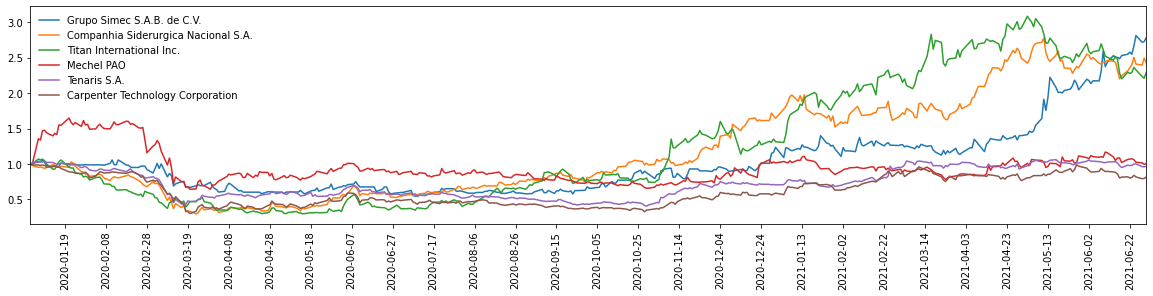

In [10]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)


for market_index in top3_down3:
    ax.plot(df_return_in_period[market_index], label=market_index)

date_min = df_return_in_period.index.min()
date_max = df_return_in_period.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

In [11]:
df_daily_return = df_steel_nyse.copy()
df_daily_return = daily_return(df_steel_nyse)
df_daily_return.head()

,Allegheny Technologies Incorporated,Arcelor Mittal,Carpenter Technology Corporation,Commercial Metals Company,Companhia Siderurgica Nacional S.A.,Friedman Industries Inc.,Gerdau S.A.,Grupo Simec S.A.B. de C.V.,Mechel PAO,Nucor Corporation,POSCO,SunCoke Energy Inc.,Tenaris S.A.,Ternium S.A.,TimkenSteel Corporation,Titan International Inc.,USA Steel Corporation,Worthington Industries Inc.
Date,,,,,,,,,,,,,,,,,,
2020-01-03,-0.437851,-4.622425,-1.404315,-0.763534,-2.234728,-0.829883,-2.587211,0.096481,-0.496278,-1.333231,-1.773092,-3.457135,1.709441,-1.776244,-1.171128,0.269905,-0.742118,-1.230261
2020-01-06,-2.019275,-1.489453,-0.020502,-0.270878,-2.575247,0.498758,0.000000,3.691856,30.982321,-0.849339,-1.825344,4.583457,0.692943,-2.771018,0.652321,6.521215,0.464471,-0.072848
2020-01-07,1.088577,1.252632,-0.575657,2.367762,0.289436,0.000000,1.401428,-1.027572,-1.470613,-0.222757,0.020237,0.796820,0.945021,-1.065069,0.129951,-1.270664,3.102440,-0.755819
2020-01-08,-3.200270,0.708798,0.514140,2.269851,-0.579711,-1.000015,0.594645,3.142589,9.531017,-0.241885,1.286966,1.104979,-0.815624,2.027722,0.518135,1.017820,-0.269903,0.024467
2020-01-09,-2.939112,-0.886790,-0.617284,-1.609784,-1.464154,0.334448,-1.393061,-3.518883,0.336134,-0.335884,1.723325,-3.352270,1.242248,2.522654,-2.088847,-2.046111,-2.278003,-1.454123


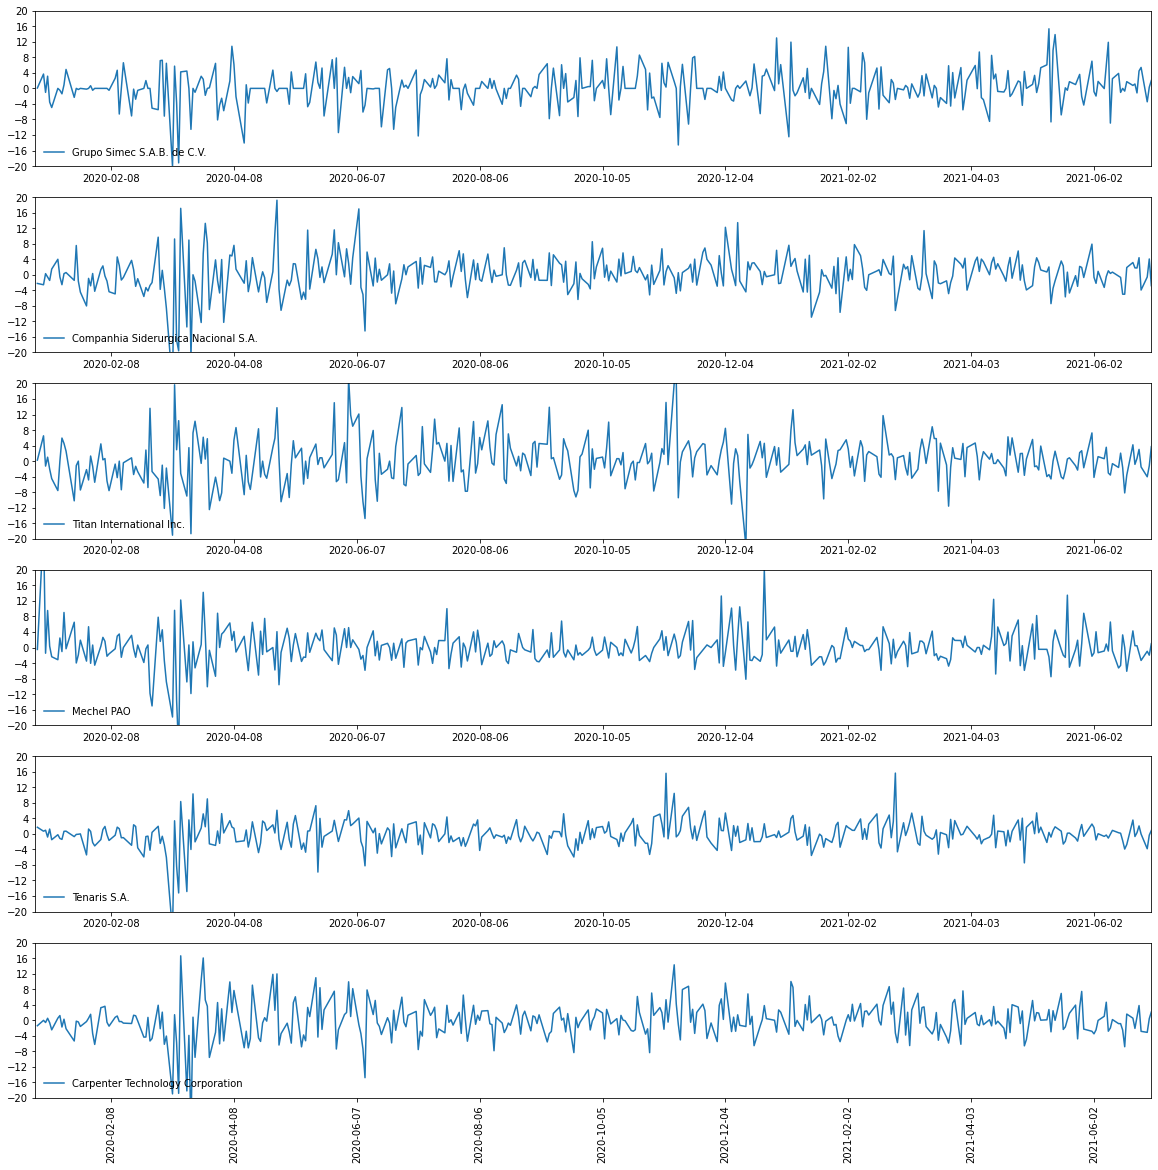

In [12]:
fig, axs = plt.subplots(nrows=len(top3_down3), figsize=(20,20))

for i, column in enumerate(top3_down3):
    axs[i].plot(df_daily_return[column], label=column)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(10))
    axs[i].set_ylim(-20, 20)
    axs[i].set_xlim(left=date_min, right=date_max)
    axs[i].legend(loc='lower left', frameon=False)

plt.xticks(rotation=90)
plt.show();

## Binarizando retornos diários

In [13]:
df_clustered = df_daily_return.copy()
df_clustered = binary_clustering(df_clustered)
df_clustered = df_clustered[[column for column in df_clustered.columns if 'cluster_' in column]]
df_clustered.head()

,cluster_Allegheny Technologies Incorporated,cluster_Arcelor Mittal,cluster_Carpenter Technology Corporation,cluster_Commercial Metals Company,cluster_Companhia Siderurgica Nacional S.A.,cluster_Friedman Industries Inc.,cluster_Gerdau S.A.,cluster_Grupo Simec S.A.B. de C.V.,cluster_Mechel PAO,cluster_Nucor Corporation,cluster_POSCO,cluster_SunCoke Energy Inc.,cluster_Tenaris S.A.,cluster_Ternium S.A.,cluster_TimkenSteel Corporation,cluster_Titan International Inc.,cluster_USA Steel Corporation,cluster_Worthington Industries Inc.
Date,,,,,,,,,,,,,,,,,,
2020-01-03,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
2020-01-06,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,1,1,0
2020-01-07,1,1,0,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0
2020-01-08,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1
2020-01-09,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0


## Achando uma estrutura da rede bayesiana

### Sem impor restrições

((2, 3), (2, 16, 17), (3, 17), (), (5, 6), (9,), (1, 13), (2,), (10, 13), (3, 17), (2, 6), (2, 9), (1, 9), (16, 17), (2, 16), (2, 11), (0, 9), (3,))
((2, 3), (2, 16, 17), (3, 17), (), (5, 6), (9,), (1, 13), (2,), (10, 13), (3, 17), (2, 6), (2, 9), (1, 9), (16, 17), (2, 16), (2, 11), (0, 9), (3,))
((2, 3), (10,), (1, 17), (2, 9), (1, 6), (9,), (10, 13), (), (), (1, 17), (8,), (2, 9), (1, 9), (16, 17), (2, 16), (2, 11), (1, 9), (1, 10))
((), (17,), (0,), (9,), (6,), (9,), (1,), (2,), (10,), (17,), (1,), (9,), (1,), (1,), (16,), (2,), (9,), (2,))
CPU times: user 50.5 s, sys: 976 ms, total: 51.5 s
Wall time: 52 s


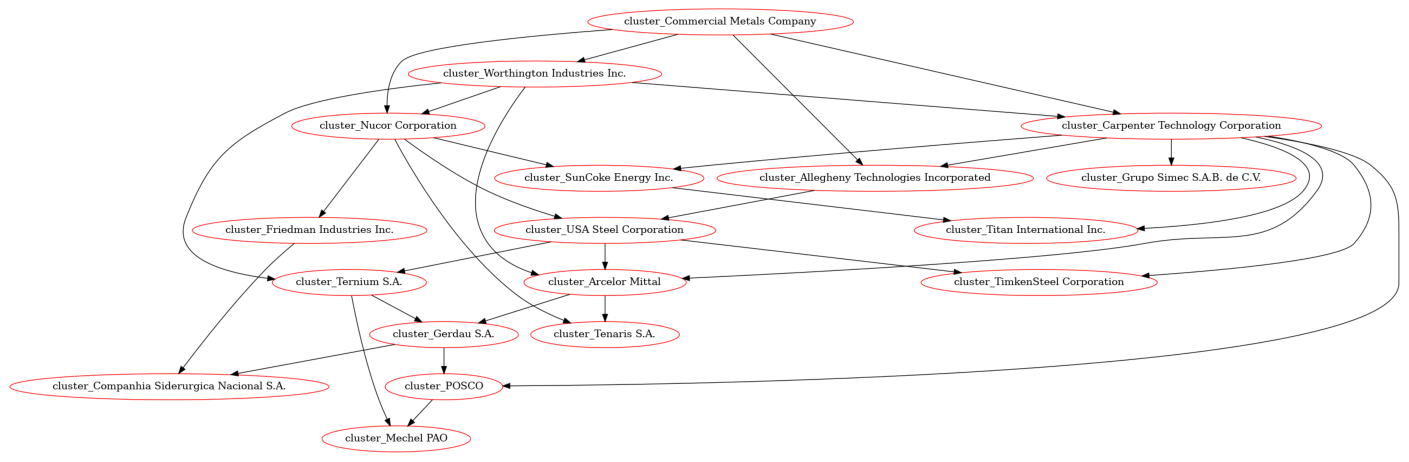

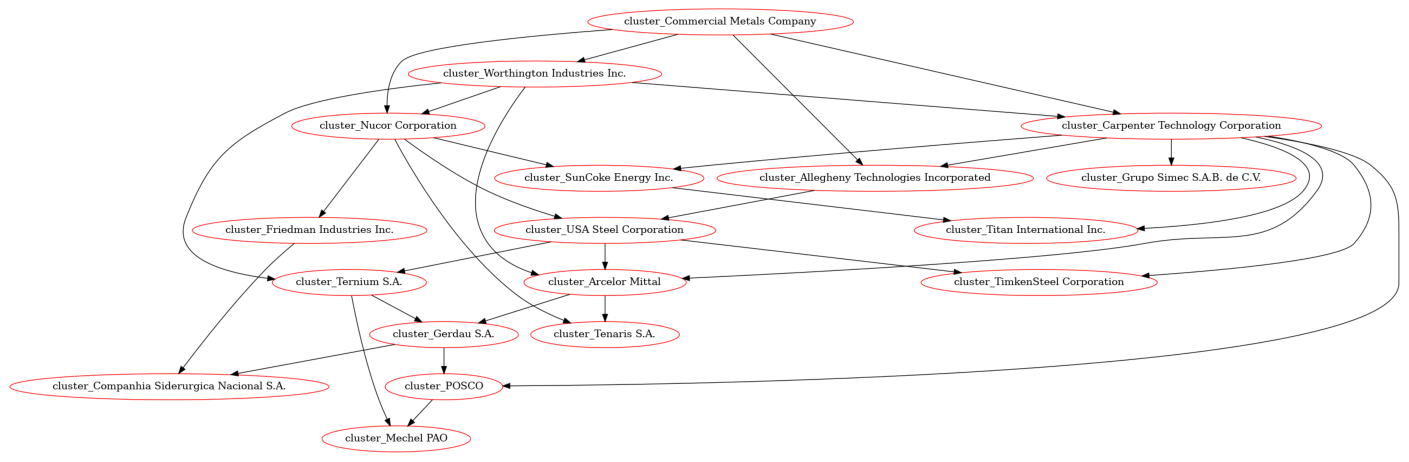

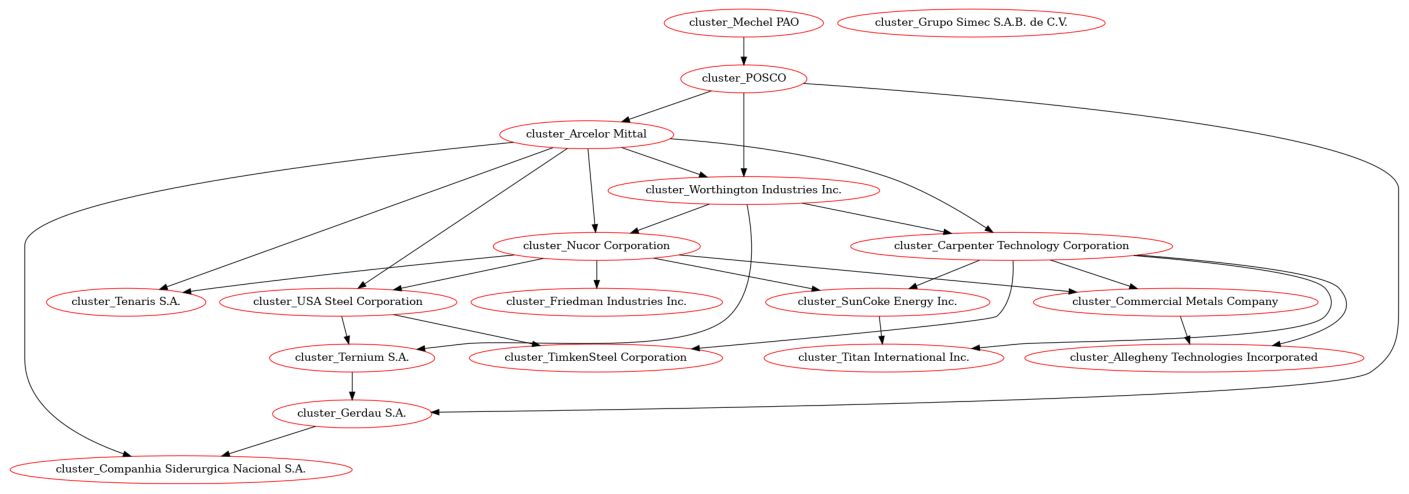

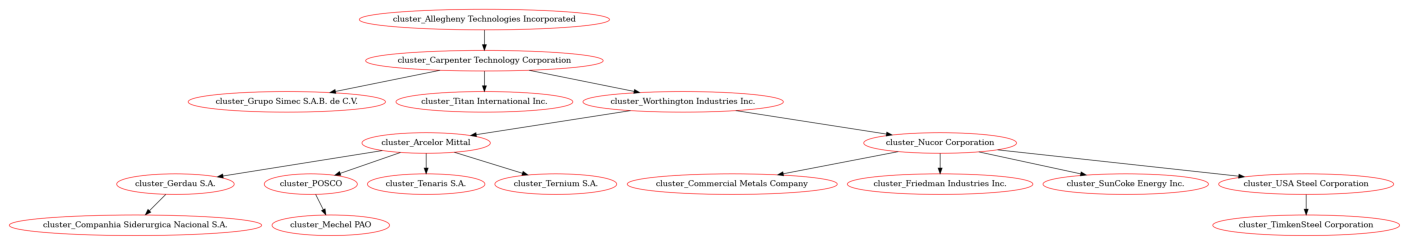

In [15]:
%%time

algorithms = ['exact-dp', 'exact', 'greedy', 'chow-liu']

for algorithm in algorithms:
    model = BayesianNetwork.from_samples(df_clustered, algorithm=algorithm, state_names=df_clustered.columns)
    print(model.structure)
    plt.figure(figsize=(25, 20))
    model.plot()

### Impondo restrições

Constraint Graph


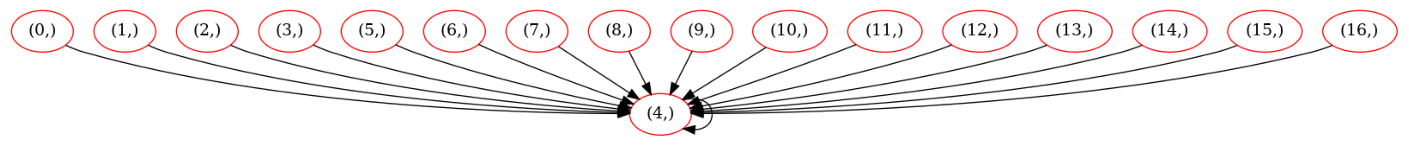

In [24]:
a = networkx.DiGraph()
target = 'cluster_Companhia Siderurgica Nacional S.A.'

for i in range(len(df_clustered.columns)-1):
    a.add_edge(tuple([i]), tuple([df_clustered.columns.get_loc(target)]))

print("Constraint Graph")
plt.figure(figsize=(25, 10))
plot_networkx(a)
plt.show()

((2, 3), (2, 16, 17), (3, 17), (), (5, 6), (9,), (1, 13), (2,), (10, 13), (3, 17), (2, 6), (2, 9), (1, 9), (16, 17), (2, 16), (2, 11), (0, 9), (3,))
((), (), (), (), (5, 6), (), (), (), (), (), (), (), (), (), (), (), (), ())
((2, 3), (10,), (1, 17), (2, 9), (1, 6), (9,), (10, 13), (), (), (1, 17), (8,), (2, 9), (1, 9), (16, 17), (2, 16), (2, 11), (1, 9), (1, 10))
((), (17,), (0,), (9,), (6,), (9,), (1,), (2,), (10,), (17,), (1,), (9,), (1,), (1,), (16,), (2,), (9,), (2,))
CPU times: user 33 s, sys: 730 ms, total: 33.7 s
Wall time: 34.2 s


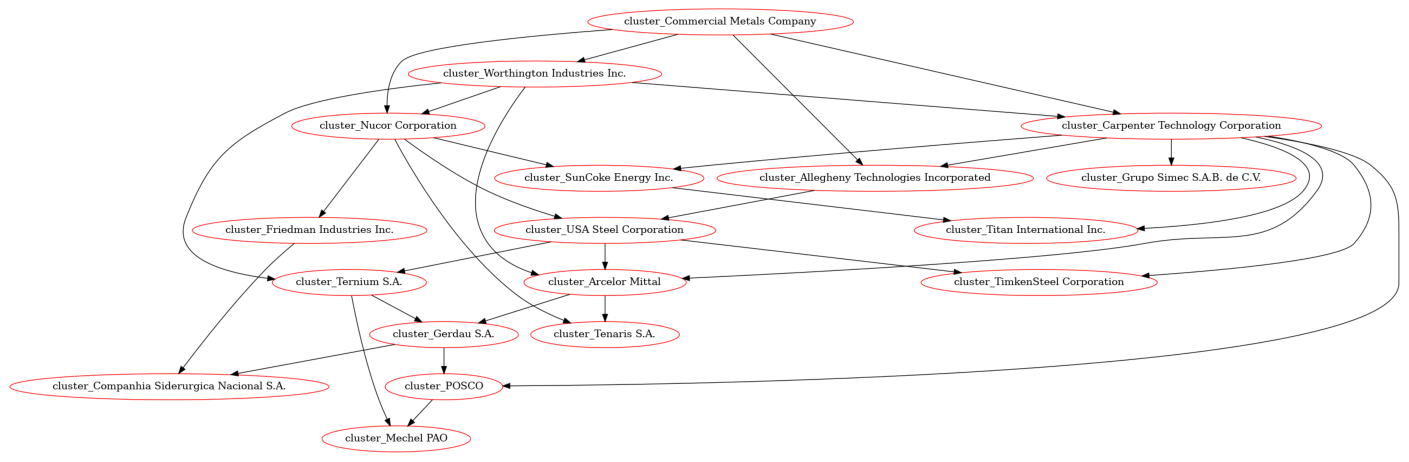

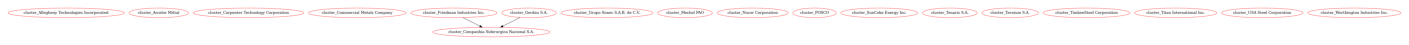

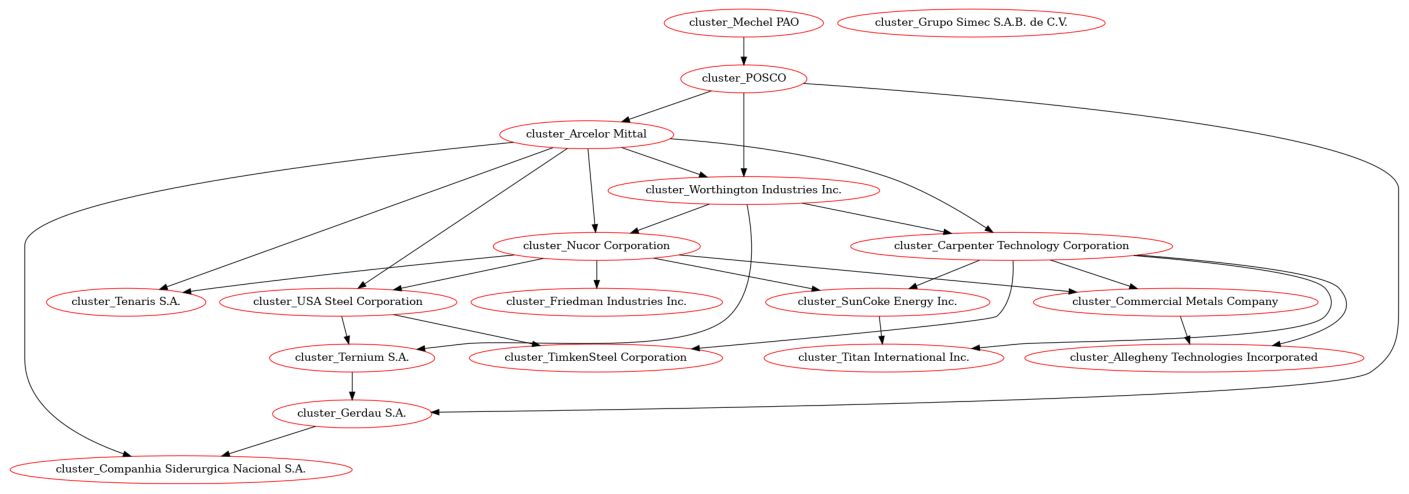

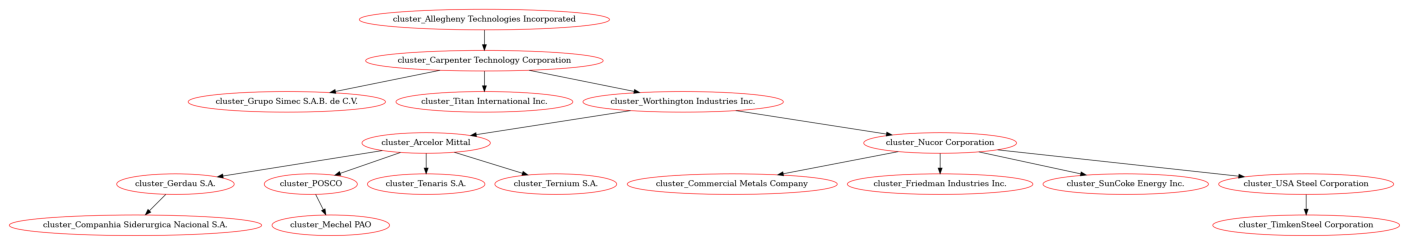

In [29]:
%%time

for algorithm in algorithms:
    model = BayesianNetwork.from_samples(df_clustered, algorithm=algorithm, state_names=df_clustered.columns, constraint_graph=a)
    print(model.structure)
    plt.figure(figsize=(25, 20))
    model.plot()